# Stability of uniform firing rate distribution

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

from disp import set_plot

In [2]:
# numeric params for computing MF quantities
DX = .05
X_MIN = -50  # same results as if using 200
X_MAX = 50

X = np.linspace(X_MIN, X_MAX, int((X_MAX-X_MIN)/DX)+1)

def norm(x, mu, sgm):
    if sgm == 0:
        temp = np.zeros(X.shape)
        temp[np.argmin(np.abs(X))] = 1/DX
        return temp
    
    return stats.norm.pdf(x, loc=mu, scale=sgm)

def phi(x, mu, sgm):
    if sgm == 0:
        temp = (X >= 0).astype(float)
        temp[X == 0] = .5
        return temp
    
    return stats.norm.cdf(x, loc=mu, scale=sgm)

def alph(th, u, v, D, mu_j, sgm_j, N=np.inf):
    """
    th \in [0, 1]^D
    u \in R^D
    v \in R_+^D
    D scalar
    mu_j \in R^{DxD}
    sgm_j \in R^{DxD}
    """
    mu_d = D*(mu_j @ th) + u
    sgm_d = np.sqrt(D*((sgm_j**2)@th) + v)
    
    phis = np.array([phi(X, mu_d_, sgm_d_) for mu_d_, sgm_d_ in zip(mu_d, sgm_d)])
    
    mnot_d = ~np.eye(len(th), dtype=bool) # masks for selecting all but one d
    
    th_next = np.nan*np.zeros(D)
    for d, (mu_d_, sgm_d_) in enumerate(zip(mu_d, sgm_d)):
        
        mask_d = mnot_d[d]
        th_next[d] = min(np.sum(norm(X, mu_d_, sgm_d_) * np.prod(phis[mask_d, :], axis=0))*DX, 1)
        
    if np.isinf(N):
        return th_next
    else:
        return np.random.multinomial(N, th_next)/N
    
def get_jac(th_0, mu_j, sgm_j, eps):
    D = len(th_0)
    jac = np.nan*np.zeros((D, D))
    
    alph_0 = alph(th_0, 0, 0, D, mu_j, sgm_j)
    
    for d in range(D):
        alph_d = alph(th_0 + eps*np.eye(D)[:, d], 0, 0, D, mu_j, sgm_j)
        jac[:, d] = (alph_d-alph_0)/eps
        
    return jac

In [3]:
def get_lam_max(D, mu_0, mu_1, sgm_0, sgm_1, eps=1e-12):
    """Numeric estimate of maximum eigenvalue of MFT dynamics at central fixed point."""
    th_0 = np.ones(D)/D  # central fixed point
    
    # means
    mu_j = np.zeros((D, D))
    mu_j[np.eye(D, dtype=bool)] = mu_0
    mu_j[~np.eye(D, dtype=bool)] = mu_1
    
    # sgms
    sgm_j = np.zeros((D, D))
    sgm_j[np.eye(D, dtype=bool)] = sgm_0
    sgm_j[~np.eye(D, dtype=bool)] = sgm_1
    
    # estimate jacobian at th_0
    jac = get_jac(th_0, mu_j, sgm_j, eps)
    
    # get eigenvalues (note that we expect a zero eigenvalue in the (1, 1, ..., 1) direction)
    evs, evecs = np.linalg.eig(jac)
    
    lam_max = np.max(evs)
    
    return lam_max, evs, evecs

In [4]:
# lam max vs D for diff param sets
DS = np.arange(2, 41)
mu_0_mu_1_sgm_0_sgm_1s = [
    # mean-driven
    (0, 0, 1, 1),
    (1, 0, 1, 1),
    (2, 0, 1, 1),
    (3, 0, 1, 1),
    
    # fluctuation-driven
    (0, 0, 1, 1),
    (0, 0, 5, 1),
    (0, 0, 10, 1),
    (0, 0, 10, 0),
]

lam_maxs_all = []

for mu_0, mu_1, sgm_0, sgm_1 in mu_0_mu_1_sgm_0_sgm_1s:
    lam_maxs = np.nan * np.zeros(len(DS))
    
    for cD, D in enumerate(DS):
        lam_maxs[cD] = get_lam_max(D, mu_0, mu_1, sgm_0, sgm_1)[0]
        
    lam_maxs_all.append(lam_maxs)

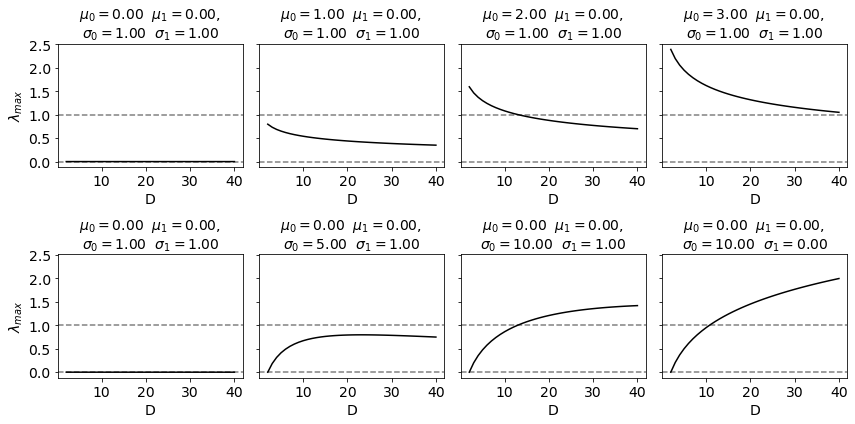

In [5]:
fig, axs = plt.subplots(2, 4, figsize=(12, 6), tight_layout=True, sharey=True)

for ax, lam_maxs, (mu_0, mu_1, sgm_0, sgm_1) in zip(axs.flat, lam_maxs_all, mu_0_mu_1_sgm_0_sgm_1s):
    
    ax.axhline(0, color='gray', ls='--')
    ax.axhline(1, color='gray', ls='--')
    ax.plot(DS, lam_maxs, lw=1.5, c='k')
    
    title = r'$\mu_0 =$' + f'{mu_0:.2f}' + r'  $\mu_1 =$' + f'{mu_1:.2f}, \n' + \
        r'$\sigma_0 =$' + f'{sgm_0:.2f}' + r'  $\sigma_1 =$' + f'{sgm_1:.2f}'
    set_plot(ax, x_label='D', title=title, font_size=14)
    
for ax in axs[:, 0]:
    set_plot(ax, y_label=r'$\lambda_{max}$', font_size=14)

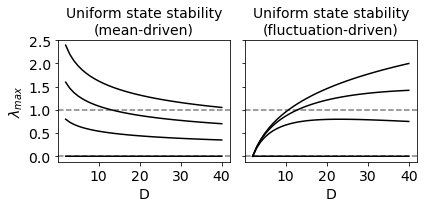

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(6, 3), tight_layout=True, sharey=True)

for lam_maxs, (mu_0, mu_1, sgm_0, sgm_1) in zip(lam_maxs_all[:len(lam_maxs_all)//2], mu_0_mu_1_sgm_0_sgm_1s):
    axs[0].plot(DS, lam_maxs, lw=1.5, c='k')
set_plot(axs[0], title='Uniform state stability\n(mean-driven)')

set_plot(axs[0], y_label=r'$\lambda_{max}$')

for lam_maxs, (mu_0, mu_1, sgm_0, sgm_1) in zip(lam_maxs_all[len(lam_maxs_all)//2:], mu_0_mu_1_sgm_0_sgm_1s):
    axs[1].plot(DS, lam_maxs, lw=1.5, c='k')
set_plot(axs[1], title='Uniform state stability\n(fluctuation-driven)')

for ax in axs:
    ax.axhline(0, color='gray', ls='--', zorder=-1)
    ax.axhline(1, color='gray', ls='--', zorder=-1)
    set_plot(ax, x_label='D', font_size=14)

fig.savefig('figs/main/4_multi_lam_max_md_fd.svg')

## Predictions for specific param values to compare to numerics

In [7]:
DS = np.arange(2, 20)

In [8]:
# mean-driven
mu_0_md = 1.5
mu_1_md = 0
sgm_0_md = 1
sgm_1_md = 1

lam_maxs_md = np.nan * np.zeros(len(DS))

for cD, D in enumerate(DS):
    lam_maxs_md[cD] = get_lam_max(D, mu_0_md, mu_1_md, sgm_0_md, sgm_1_md)[0]
    
# fluct-driven
mu_0_fd = 0
mu_1_fd = 0
sgm_0_fd = 1
sgm_1_fd = 0

lam_maxs_fd = np.nan * np.zeros(len(DS))

for cD, D in enumerate(DS):
    lam_maxs_fd[cD] = get_lam_max(D, mu_0_fd, mu_1_fd, sgm_0_fd, sgm_1_fd)[0]

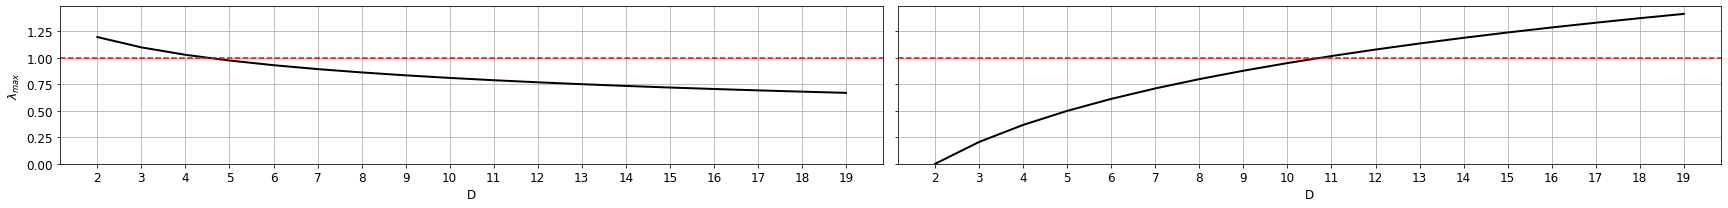

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(24, 3), tight_layout=True, sharey=True)

axs[0].plot(DS, lam_maxs_md, c='k', lw=2)
axs[0].set_ylabel(r'$\lambda_{max}$')
axs[1].plot(DS, lam_maxs_fd, c='k', lw=2)

for ax in axs:
    ax.axhline(1, ls='--', c='r')
    ax.set_ylim(bottom=0)
    ax.grid()
    set_plot(ax, x_ticks=DS, x_label='D', font_size=12)